## Loading libraries and data

In [1]:
import sys
import os
import gc

sys.path.append("../src")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import cufflinks as cf

cf.go_offline()

import pmdarima as pm
from hts import HTSRegressor

import statsmodels.api as sm
import statsmodels.tsa.api as smt

from visualize import get_nodes_edges_position, make_annotations, tsplot

/home/v086200/anaconda3/envs/m5/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_hier_sales = pd.read_csv("../data/preprocessed/M5_hierarchical_data.csv")
df_hier_sales.head(4)

,total,state_id,store_id,cat_id,dept_id,2011-01-29,2011-01-30,2011-01-31,2011-02-01,2011-02-02,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
0,Total,CA,CA_1,FOODS,FOODS_1,297,284,214,175,182,...,293,317,268,302,237,287,297,331,419,329
1,Total,CA,CA_1,FOODS,FOODS_2,674,655,396,476,354,...,435,499,637,529,391,423,365,489,590,734
2,Total,CA,CA_1,FOODS,FOODS_3,2268,2198,1398,1607,1496,...,1978,2665,3099,2055,1860,1780,1871,2140,2646,2990
3,Total,CA,CA_1,HOBBIES,HOBBIES_1,528,489,409,383,263,...,370,690,597,517,461,333,380,471,621,641


### Minimal Dataprep and Filtering

Let's melt our data so we have our data represented in tidy format as well as removing day 25-12 where I know apriori that majority of stores were closed due to Walmart's policy. Regarding other components of data preparation, I left to a minimal level here, any issue will be treated in *hierarchical-data-definition* and then here we will always get most recent data for modelling.

In [3]:
df_hier = (
  df_hier_sales.melt(id_vars=["total", "dept_id", "store_id", "state_id", "cat_id"],
                    var_name="date",
                    value_name="unit_solds")
               .assign(date=lambda df: pd.to_datetime(df['date']))
)

df_hier.head(4)

,total,dept_id,store_id,state_id,cat_id,date,unit_solds
0,Total,FOODS_1,CA_1,CA,FOODS,2011-01-29,297
1,Total,FOODS_2,CA_1,CA,FOODS,2011-01-29,674
2,Total,FOODS_3,CA_1,CA,FOODS,2011-01-29,2268
3,Total,HOBBIES_1,CA_1,CA,HOBBIES,2011-01-29,528


In [4]:
df_hier.shape

(133910, 7)

We will use scikit-hts library, so we need to transform each column in our dataset in a time series relating to a branch in our hierarchical level.

In [5]:
df_hier['id'] = df_hier.apply(lambda x: f"{x['state_id']}_{x['store_id']}_{x['cat_id']}_{x['dept_id']}", axis=1)
df_hier['store_cat_id'] = df_hier.apply(lambda x: f"{x['store_id']}_{x['cat_id']}", axis=1)
df_hier['store_cat_dept_id'] = df_hier.apply(lambda x: f"{x['store_id']}_{x['cat_id']}_{x['dept_id']}", axis=1)

In [6]:
def return_agg_by_hier(df, column):
    return df.pivot_table(index='date', columns=column, values='unit_solds', aggfunc='sum')

df_states = return_agg_by_hier(df_hier, column='state_id')
df_stores = return_agg_by_hier(df_hier, column='store_id')
df_cats = return_agg_by_hier(df_hier, column='store_cat_id')
df_depts = return_agg_by_hier(df_hier, column='store_cat_dept_id')

In [7]:
df_total = (df_states['CA'] + df_states['WI'] + df_states['TX']).to_frame(name="total")

In [8]:
df_all = pd.concat([df_total, df_states, df_stores, df_cats, df_depts], axis=1)
df_all.head(5)

,total,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,...,WI_2_HOBBIES_HOBBIES_2,WI_2_HOUSEHOLD_HOUSEHOLD_1,WI_2_HOUSEHOLD_HOUSEHOLD_2,WI_3_FOODS_FOODS_1,WI_3_FOODS_FOODS_2,WI_3_FOODS_FOODS_3,WI_3_HOBBIES_HOBBIES_1,WI_3_HOBBIES_HOBBIES_2,WI_3_HOUSEHOLD_HOUSEHOLD_1,WI_3_HOUSEHOLD_HOUSEHOLD_2
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,32631,14195,9438,8998,4337,3494,4739,1625,2556,3852,...,10,353,98,152,583,2293,256,22,584,148
2011-01-30,31749,13805,9630,8314,4155,3046,4827,1777,2687,3937,...,7,268,94,138,585,2383,342,14,541,195
2011-01-31,23783,10108,6778,6897,2816,2121,3785,1386,1822,2731,...,18,250,69,127,575,1841,228,20,420,106
2011-02-01,25412,11047,7381,6984,3051,2324,4232,1440,2258,2954,...,15,305,80,98,533,1965,183,11,327,94
2011-02-02,19146,9925,5912,3309,2630,1942,3817,1536,1694,2492,...,1,118,32,87,340,1427,70,4,151,53


In [9]:
states = df_hier.state_id.unique()
stores = df_hier.store_id.unique()
cats = df_hier.store_cat_id.unique()
depts = df_hier.store_cat_dept_id.unique()

# Here we build the tree as a dictionary. Each node (key in dict) has a list of 
# children value in dict, which in turn may also be a key in the dict, and have 
# children as well 
total = {'total': list(states)}
state_h = {k: [v for v in stores if v.startswith(k)] for k in states}
store_h = {k: [v for v in cats if v.startswith(k)] for k in stores}
dept_h = {k: [v for v in depts if v.startswith(k)] for k in cats}

In [10]:
hierarchy = {**total, **state_h, **store_h, **dept_h}

## Endogenous variable only

### SARIMA

First, just for demonstration purposes, let's fit an ARIMA model using a manual approach for our total sales series so we can understand better what is happening under the hoods when using hierarchical method and autoarima.

#### Manual

In [11]:
df_all = df_all.resample('D').sum()
df_total = df_all['total'].copy()

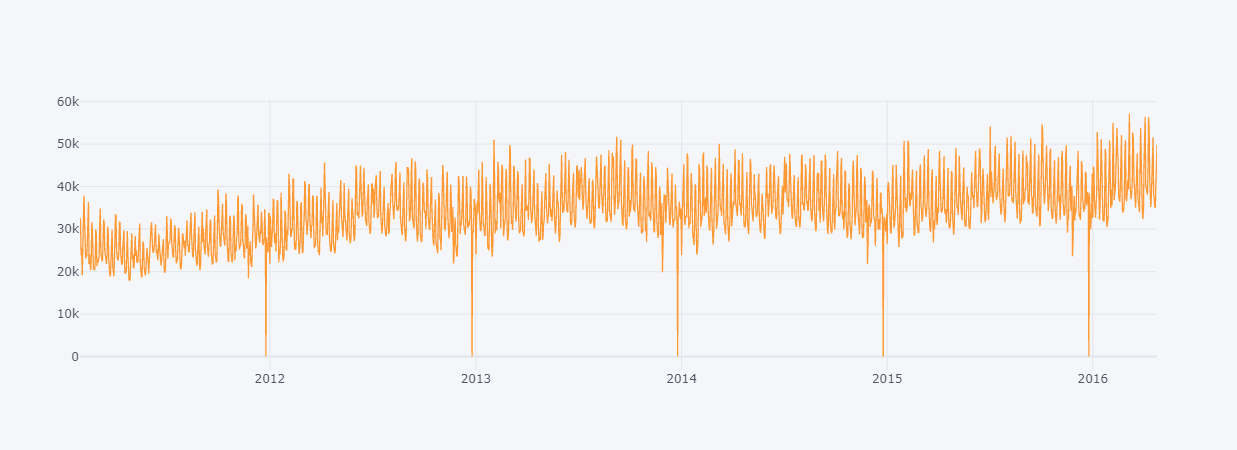

In [12]:
df_total.iplot()

The first thing we will do is to remove outliers values that comes from christmas day. Since majority of stores does not even open, it does not make sense to forecast for that day, thus I will replace values using a capping technique.

In [13]:
christmas_dates = list(map(lambda x: f"{str(x)}-12-25", [2011, 2012, 2013, 2014, 2015]))
lower_c = lower_c, upper_c = np.percentile(df_total, [1, 99])

for c_date in christmas_dates:
    df_total[c_date] = lower_c

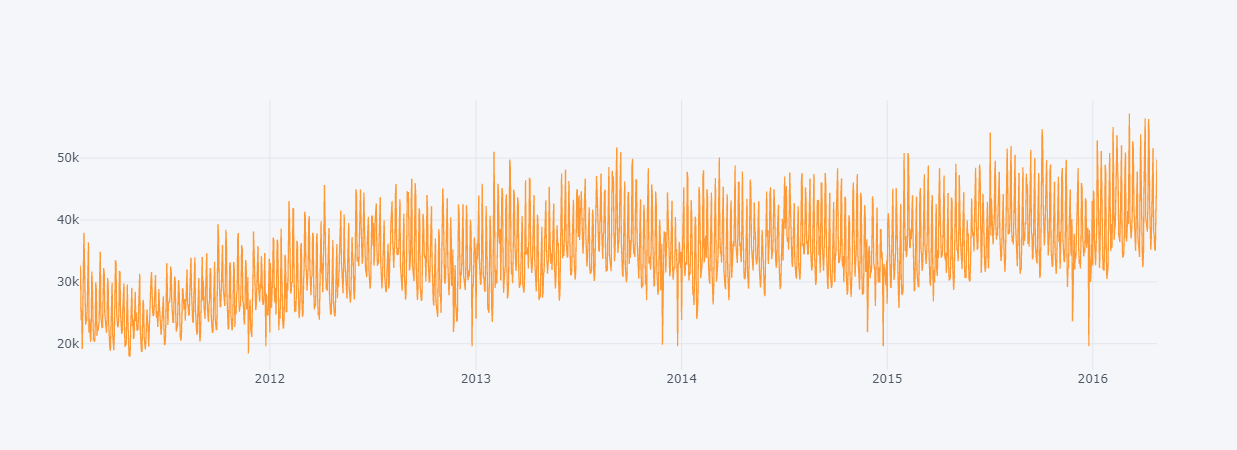

In [14]:
df_total.iplot()

From above, and 01-exploratory-data-analaysis notebook, we can check a few important assumptions in our data:

 - Our data has a linear trend.
 - There is a strong seasonality factor. This seems to be a multiple seasonal factor, for week, month and even year.
 - Outliers on christmas and thanksgiving days.
 - No apparent long-run cycle.
 - Variance seems to increase slowly with time.
 - No abrupt changes in our series.


We need to have a stationary process in order to fit an ARIMA model. Since our data has seasonal and trend factors, we need to deal with it. I will do a step by step of how we can transform our series into a stationary one.

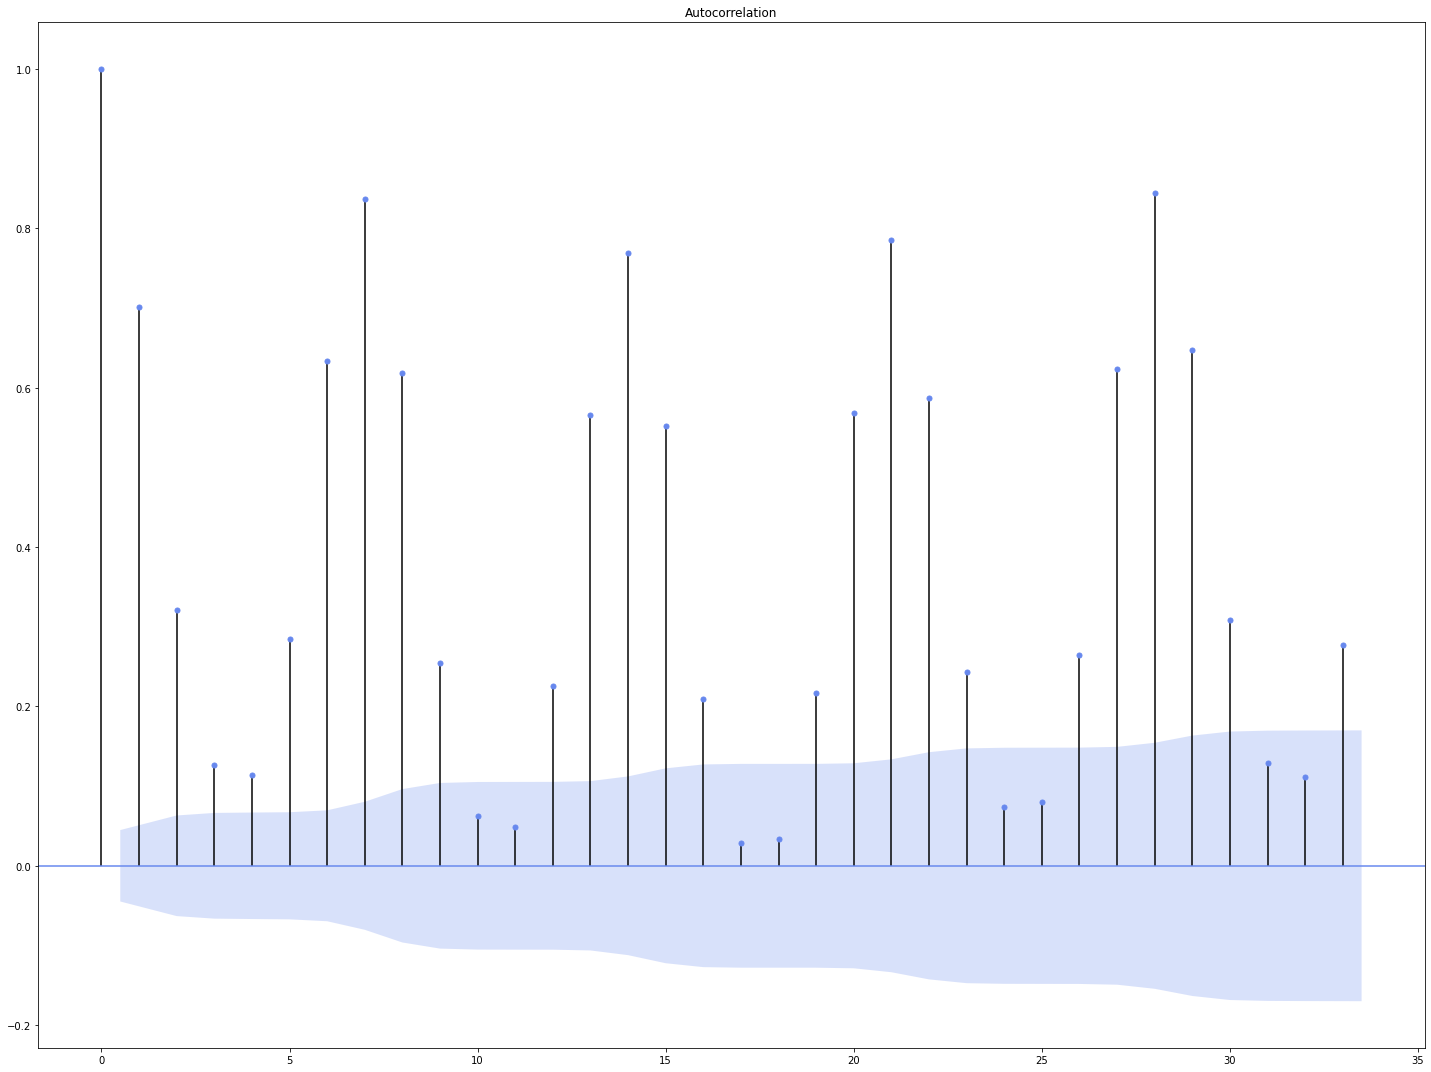

In [15]:
sns.set_palette('coolwarm')

fig, ax = plt.subplots(figsize=(20, 15))
smt.graphics.plot_acf(df_total, ax=ax)

plt.tight_layout()

We can see that our ACF plot does not look good. Weekly seasonality as we discussed, and an autocorrelation term that does not go off to zero quickly indicating a trend factor.

First, let's difference our series for weekly seasonality and then plot acf.

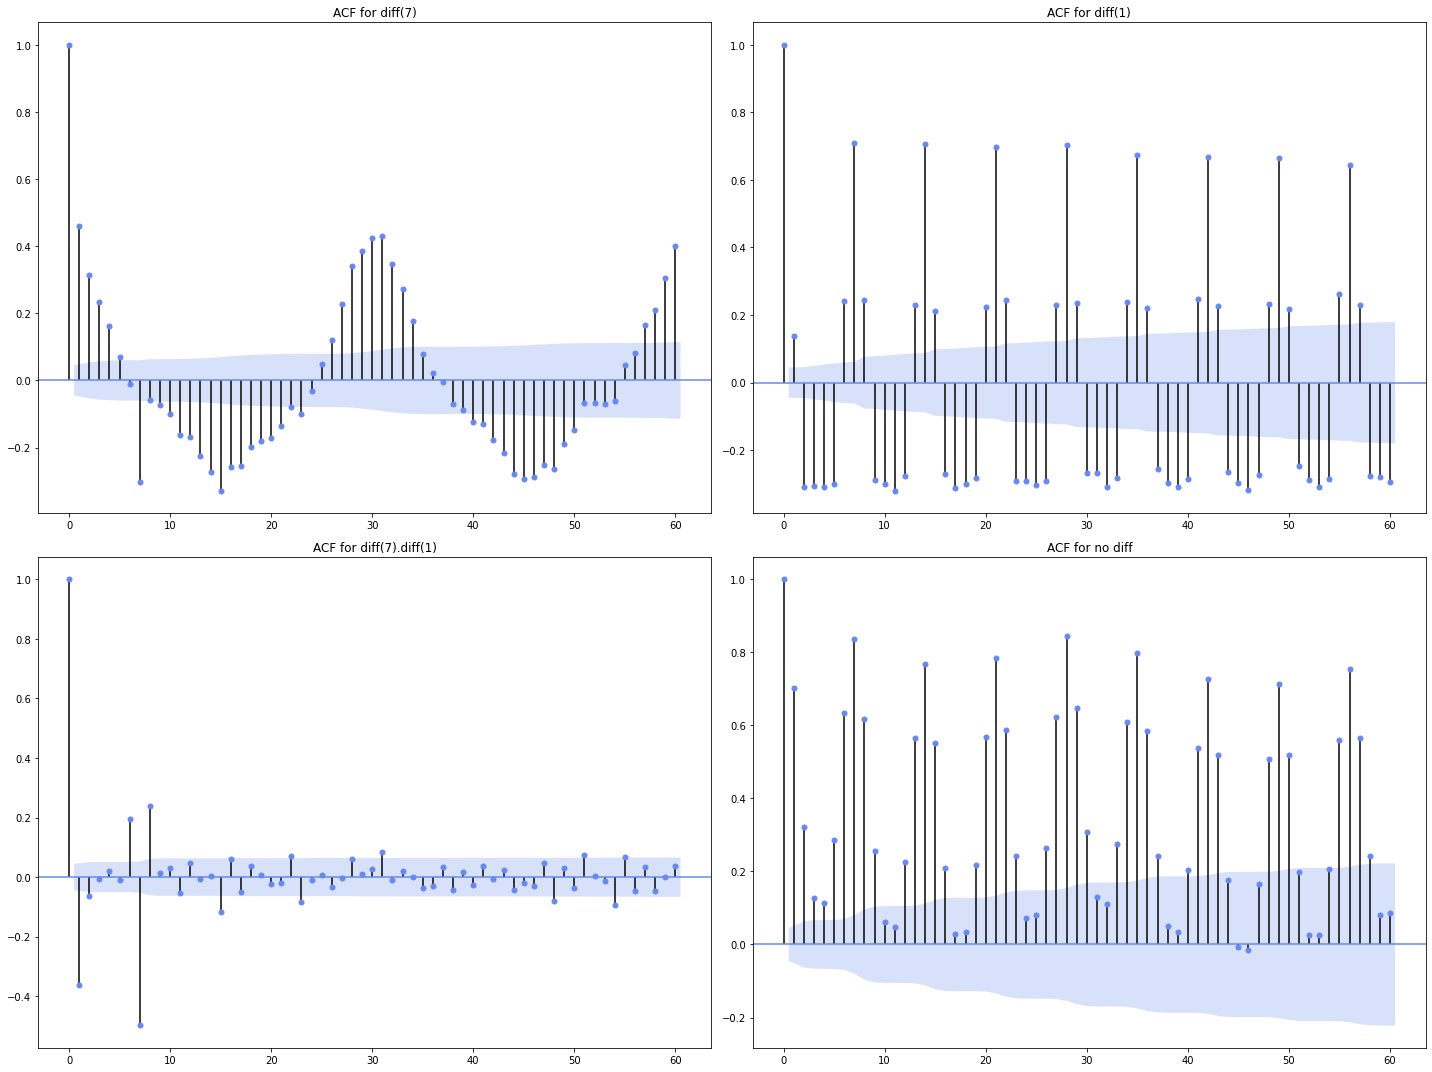

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

smt.graphics.plot_acf(df_total.diff(7).dropna(), ax=ax[0][0], lags=60, title="ACF for diff(7)")
smt.graphics.plot_acf(df_total.diff(1).dropna(), ax=ax[0][1], lags=60, title="ACF for diff(1)")
smt.graphics.plot_acf(df_total.diff(7).diff(1).dropna(), ax=ax[1][0], lags=60, title="ACF for diff(7).diff(1)")
smt.graphics.plot_acf(df_total, ax=ax[1][1], lags=60, title="ACF for no diff")

plt.tight_layout()

In the plot above we have:
 - For diff(7) only, we still have a trend that repeats in a monthly basis, a possible indication of a multiseasonal factor.
 - For diff(1) only, we have eliminated trend, however the seasonal factor remained.
 - For both terms plot shows no trend or seasonal factor. We are ready to fit an Arima Model.

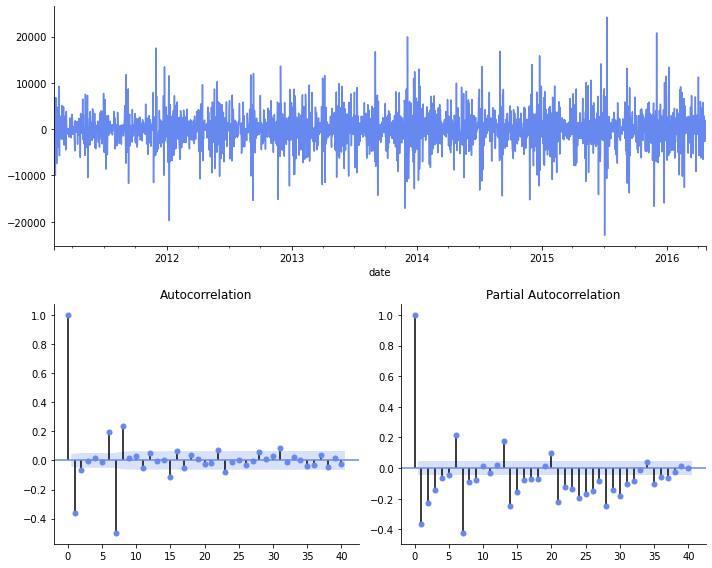

In [17]:
tsplot(df_total.diff(7).diff(1).dropna(), lags=40);

We need to define seasonal and nonseasonal terms when fitting a SARIMA model. From above plot, we can see that in both we need a differencing term for m = 7 (weekly seasonality). 

For seasonal_order:
 - Partial Autocorrelation plot shows significant lags up to 21, indicating that an AR coefficient for Seasonal 3 would be a good fit.
 - Also, it shows that MA terms in only statistical significant in first lag, we will then choose 1 as or MA Seasonal coefficient.
 
For non_seasonal_order:
 - MA order of 2 is most indicated from ACF plot.
 - For AR coefficient, it is really difficult to see some pattern from plot above, I will use value of 1 to see what happens.

In [27]:
from pmdarima.model_selection import train_test_split

train_total, test_total = train_test_split(df_total, test_size=28)

non_seasonal_order = (1, 1, 2)
seasonal_order = (3, 1, 1, 7)


model_sarima = sm.tsa.SARIMAX(train_total, order=non_seasonal_order, seasonal_order=seasonal_order)
fitted_model = model_sarima.fit()

/home/v086200/anaconda3/envs/m5/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Let's check our summary results.

In [28]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             total   No. Observations:                 1885
Model:             SARIMAX(1, 1, 2)x(3, 1, 1, 7)   Log Likelihood              -17635.283
Date:                           Fri, 12 Jun 2020   AIC                          35286.566
Time:                                   11:42:54   BIC                          35330.865
Sample:                               01-29-2011   HQIC                         35302.884
                                    - 03-27-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9121      0.020     44.647      0.000       0.872       0.952
ma.L1         -1.4499      0.027    -52.887      0.000      -1.504      -1.396
ma.L2          0.4512      0.027     17.018      0.000       0.399       0.503
ar.S.L7        0.2982      0.025     11.953      0.000       0.249       0.347
ar.S.L14       0.1982      0.026      7.560      0.000       0.147       0.250
ar.S.L21       0.0951      0.028      3.380      0.001       0.040       0.150
ma.S.L7       -0.9898      0.009   -105.495      0.000      -1.008      -0.971
sigma2      9.908e+06   5.36e-10   1.85e+16      0.000    9.91e+06    9.91e+06
===================================================================================
Ljung-Box (Q):                      359.70   Jarque-Bera (JB):               968.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.46e+30. Standard errors may be unstable.
"""

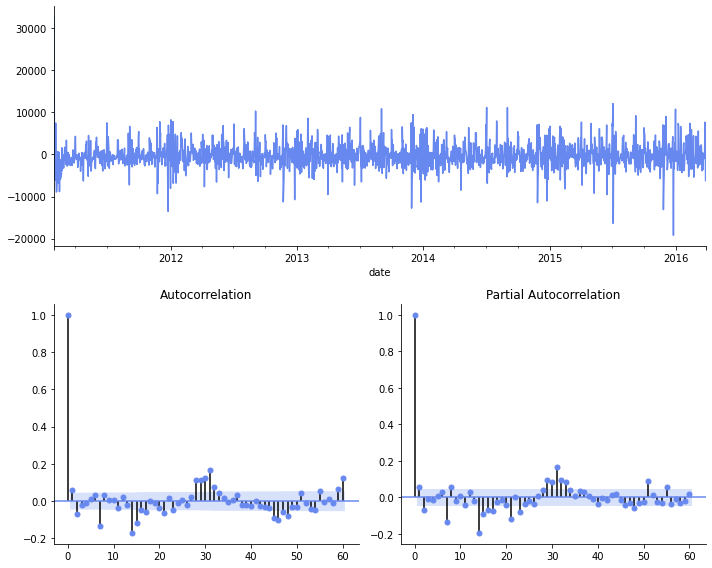

In [29]:
tsplot(fitted_model.resid, lags=60);

In [30]:
predicted = fitted_model.forecast(steps=test_total.shape[0])

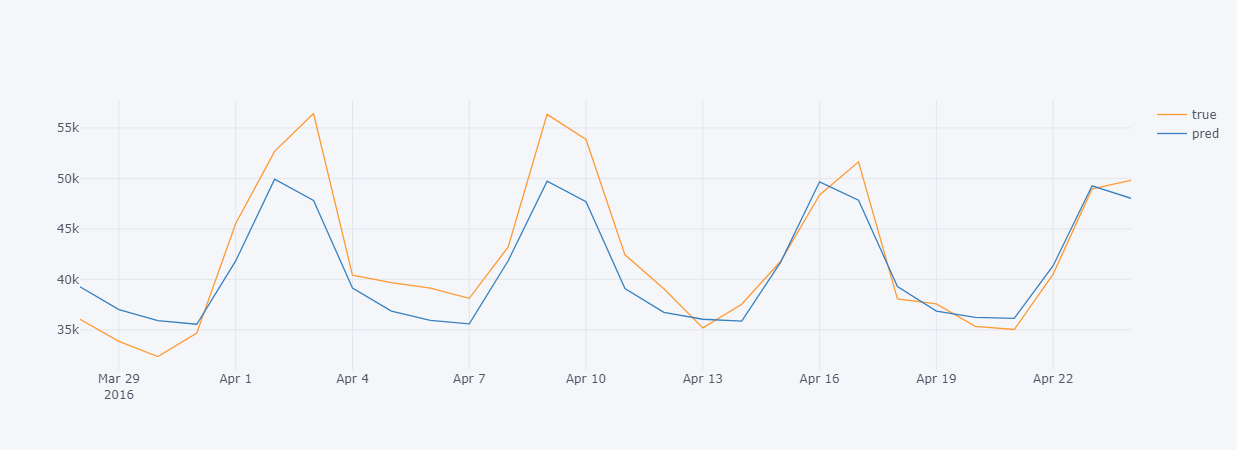

In [33]:
pd.DataFrame({"true":test_total, "pred": predicted}).iplot()

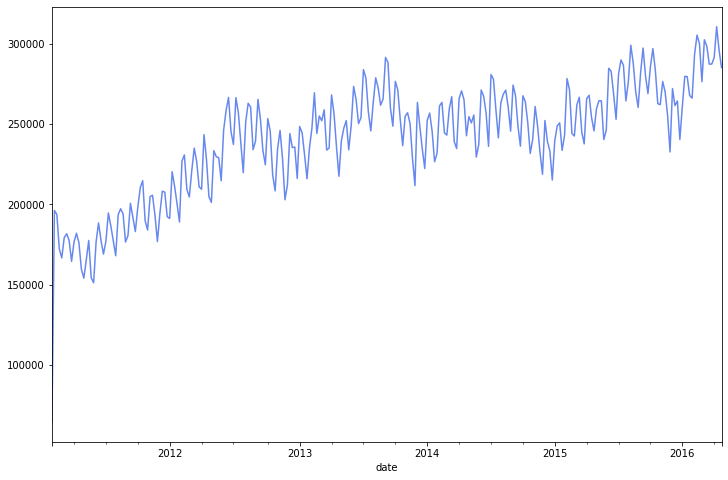

In [38]:
df_total.resample('W').sum().plot(figsize=(12, 8))

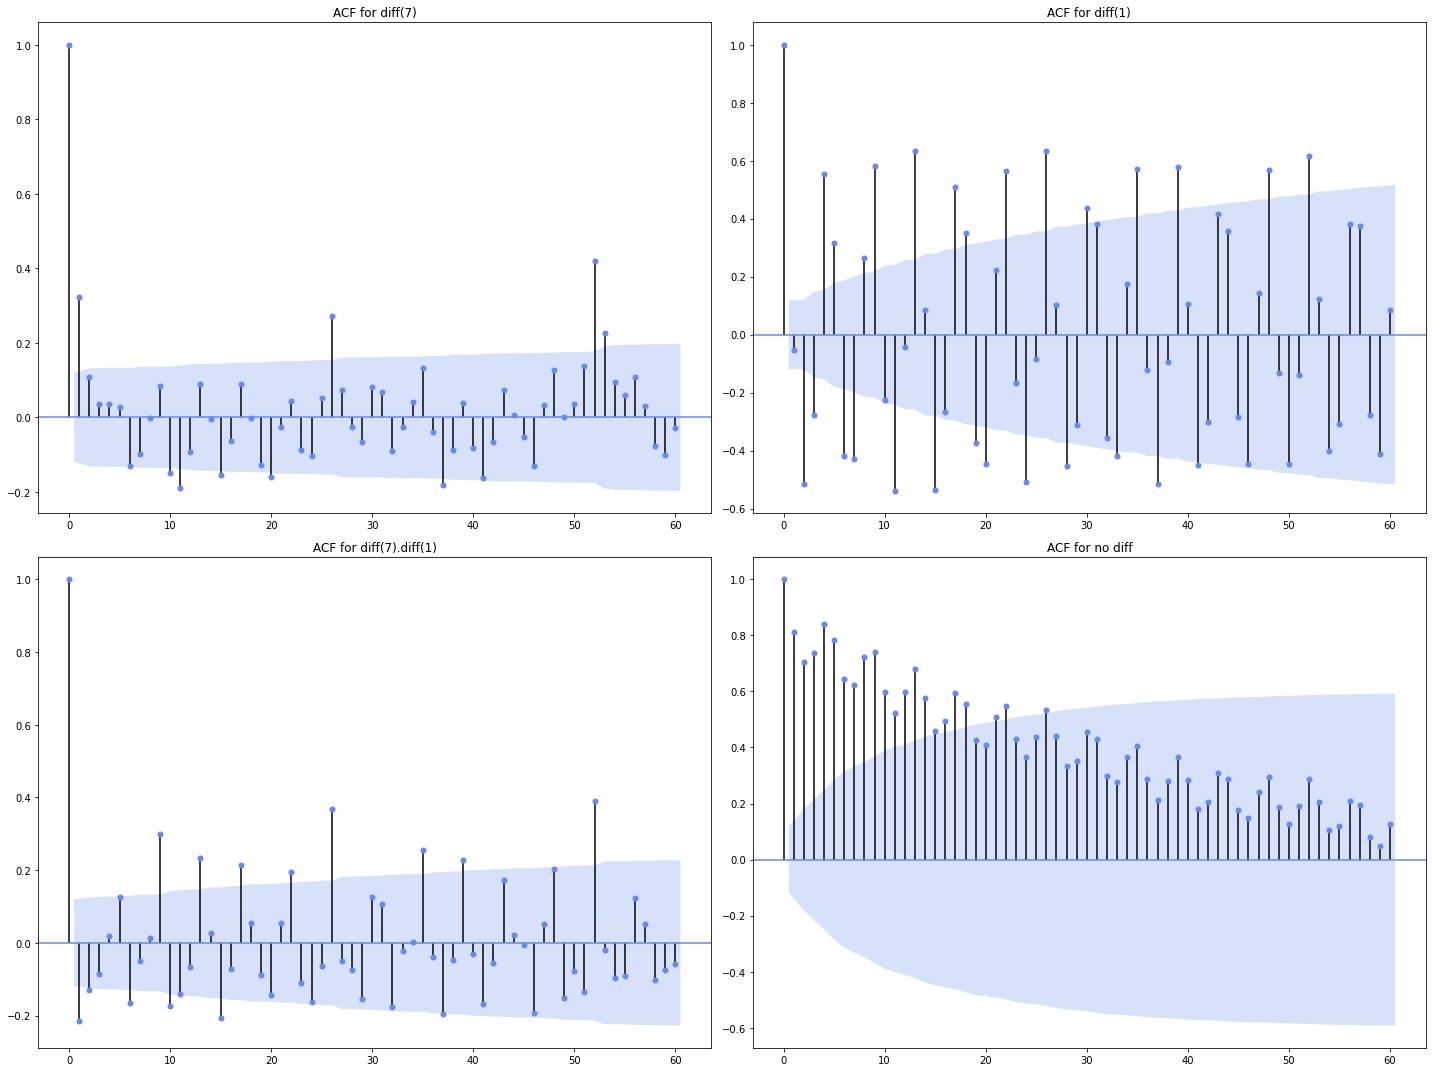

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

smt.graphics.plot_acf(df_total.resample('W').sum().diff(4).dropna(), ax=ax[0][0], lags=60, title="ACF for diff(7)")
smt.graphics.plot_acf(df_total.resample('W').sum().diff(1).dropna(), ax=ax[0][1], lags=60, title="ACF for diff(1)")
smt.graphics.plot_acf(df_total.resample('W').sum().diff(4).diff(1).dropna(), ax=ax[1][0], lags=60, title="ACF for diff(7).diff(1)")
smt.graphics.plot_acf(df_total.resample('W').sum(), ax=ax[1][1], lags=60, title="ACF for no diff")

plt.tight_layout()

In [60]:
from pmdarima.preprocessing import FourierFeaturizer
from pmdarima import pipeline
from pmdarima import arima

model_arima = arima.ARIMA(order=non_seasonal_order, seasonal=False)

pipe = pipeline.Pipeline([
    ("fourier_30", FourierFeaturizer(m=30, k=2)),
    ("fourier", FourierFeaturizer(m=7, k=2)),
    ("arima", model_arima)
])

pipe.fit(train_total)

Pipeline(steps=[('fourier_30', FourierFeaturizer(k=2, m=30, prefix=None)),
                ('fourier', FourierFeaturizer(k=2, m=7, prefix=None)),
                ('arima',
                 ARIMA(maxiter=50, method='lbfgs', order=(1, 1, 2),
                       out_of_sample_size=0, scoring='mse', scoring_args=None,
                       seasonal_order=(0, 0, 0, 0), start_params=None,
                       suppress_warnings=False, trend=None,
                       with_intercept=True))])

In [61]:
predicted_ff = pipe.predict(test_total.shape[0])

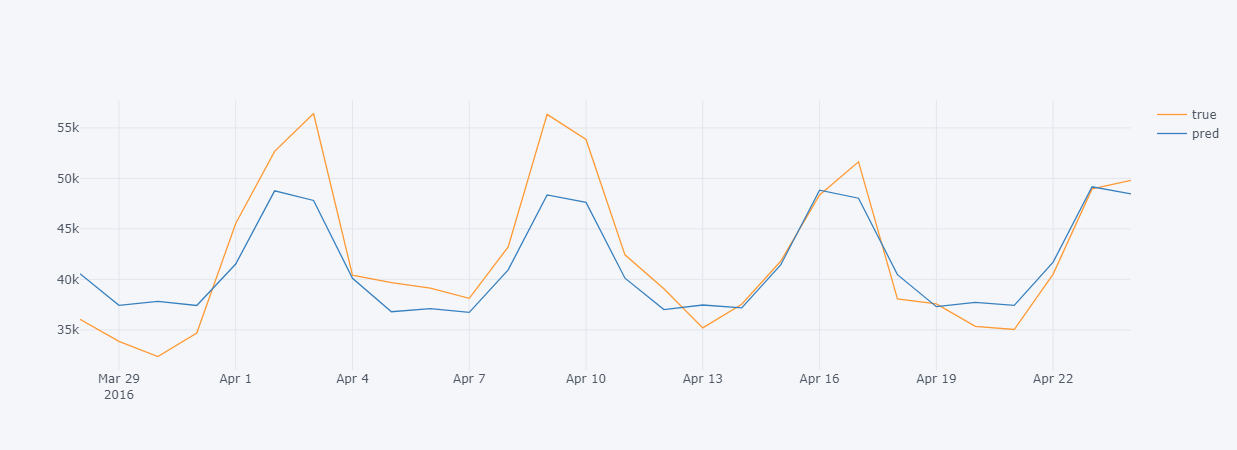

In [62]:
pd.DataFrame({"true":test_total, "pred": predicted_ff}).iplot()

In [63]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(test_total, predicted_ff)

2770.1003330537196

In [64]:
mean_absolute_error(test_total, predicted)

2503.136532232737

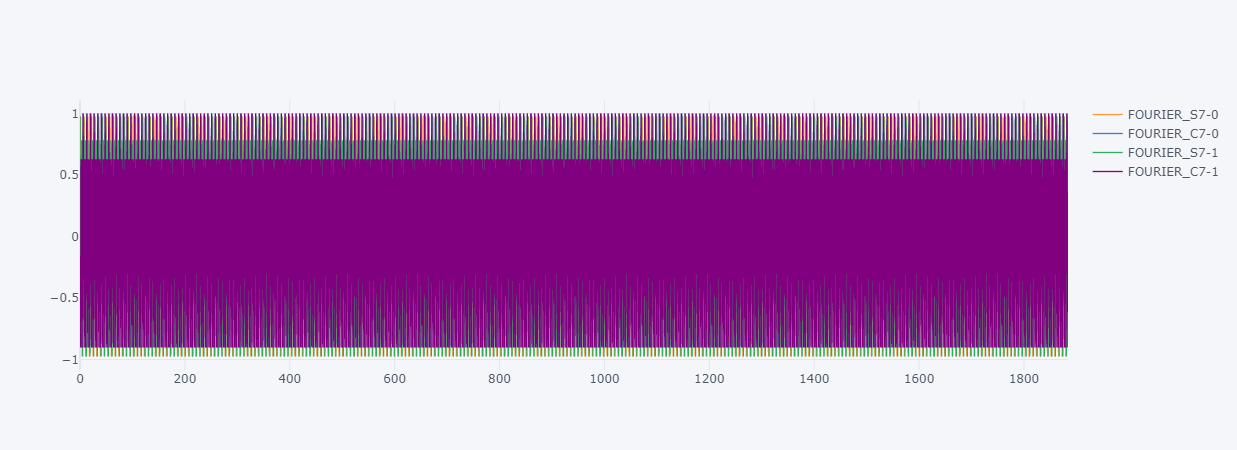

In [44]:
ff.fit_transform(train_total)[1].iplot()

scikit-hts uses auto_arima function pro library pmdarima. This will be more appropriate in our case since doing all steps required to fit a SARIMA model would be tedious and take a really long time, so our best option will let to default arguments to choose best parameters and analyze results.

In [18]:
from hts import HTSRegressor

auto_arima_args = dict(m=7)



train, test = train_test_split(df_all, test_size=28)
clf_hw_hier = HTSRegressor(model='holt_winters', revision_method='OLS', n_jobs=0)

model_hw = clf_hw_hier.fit(train, hierarchy)


Fitting models: 100%|██████████| 114/114 [00:00<00:00, 245.86it/s]


In [19]:
predicted_hw = clf_hw_hier.predict(steps_ahead=28)


Fitting models: 100%|██████████| 114/114 [00:00<00:00, 129.14it/s]


In [25]:
y_train = train
y_true = test
y_pred = predicted_hw[-test.shape[0]:]

In [30]:
hts.metrics

AttributeError: module 'hts' has no attribute 'metrics'

In [94]:
np.where(mean_absolute_scaled_error(y_true, y_pred, y_train, naive_period=1) < 1)

(array([24, 26, 32, 61, 68, 73, 74, 80, 82, 88]),)

In [97]:
mean_absolute_scaled_error(y_true, y_pred, y_train, naive_period=1).head(26)

total             1.615398
CA                1.615166
TX                1.285696
WI                1.523779
CA_1              1.429641
CA_2              1.726998
CA_3              1.550915
CA_4              1.263155
TX_1              1.219877
TX_2              1.315916
TX_3              1.211615
WI_1              1.782247
WI_2              1.780078
WI_3              1.486839
CA_1_FOODS        1.442081
CA_1_HOBBIES      1.006134
CA_1_HOUSEHOLD    1.440103
CA_2_FOODS        1.772898
CA_2_HOBBIES      1.156626
CA_2_HOUSEHOLD    1.490187
CA_3_FOODS        1.910895
CA_3_HOBBIES      1.136822
CA_3_HOUSEHOLD    1.413071
CA_4_FOODS        1.193782
CA_4_HOBBIES      0.865187
CA_4_HOUSEHOLD    1.621874
dtype: float64

In [76]:
mean_absolute_scaled_error(y_true['CA'], y_pred['CA'], y_train['CA'], naive_period=7)

AttributeError: 'Series' object has no attribute 'columns'

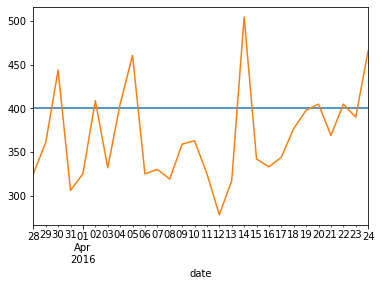

In [101]:
y_pred['CA_4_HOBBIES'].plot()
y_true['CA_4_HOBBIES'].plot()

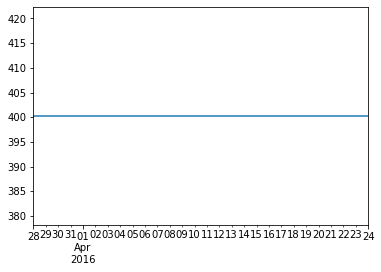

In [102]:
y_pred['CA_4_HOBBIES'].plot()

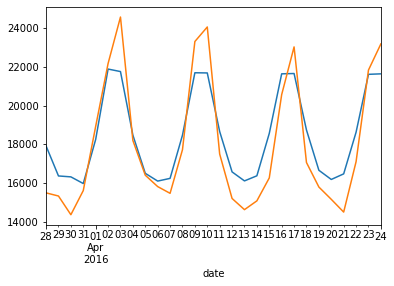

In [168]:
y_pred['CA'].plot()
y_test['CA'].plot()

### ETS

### Prophet

## Exogenous variables